In [28]:
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from imageio import imread
from skimage.transform import resize
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans

import keras
import tensorflow as tf
from keras import backend as K
from keras.applications.vgg16 import preprocess_input
import PIL.Image
#}

In [2]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU (for TensorFlow 1.X + Keras)
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

# confirm PyTorch sees the GPU
#from torch import cuda
#assert cuda.is_available()
#assert cuda.device_count() > 0
#print(cuda.get_device_name(cuda.current_device()))


Model architecture
<img src="../../data/misc/vgg16.png">

In [3]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [42]:
#Function to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
        '''
        img = imread(im_path,as_gray=False, pilmode="RGB")
        #print im_path
        #print img.shape
        if img_size:
            img = resize(img, img_size)

        img = img.astype('float32')
        # We normalize the colors (in RGB space) with the empirical means on the training set
        img[:, :, 0] -= 123.68
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 103.939
        # We permute the colors to get them in the BGR order
        if color_mode == 'bgr':
            img[:, :, [0, 1, 2]] = img[:, :, [2, 1, 0]]
        img = img.transpose((2, 0, 1))

        if crop_size:
            img = img[:, (img_size[0] - crop_size[0]) // 2:(img_size[0] + crop_size[0]) // 2
            , (img_size[1] - crop_size[1]) // 2:(img_size[1] + crop_size[1]) // 2]

        img_list.append(img)
        '''
        size = 224
        ret = PIL.Image.open(im_path)
        ret = ret.resize((size, size))
        ret = np.asarray(ret, dtype=np.uint8).astype(np.float32)
        #ret[:, :, 0] -= 123.68
        #ret[:, :, 1] -= 116.779
        #ret[:, :, 2] -= 103.939
        if ret.ndim == 2:
            ret.resize((size, size, 1))
            ret = np.repeat(ret, 3, axis=-1)
        #ret = ret.transpose((2, 0, 1))
        #ret = np.flip(ret,0)
        x = preprocess_input(ret)
        #print(x.shape)
        img_list.append(x)
        

    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print(im_path)
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [14]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error

In [8]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids

In [9]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print('##########', ind_)
            pass
        line_num += 1
#}

In [21]:
backend.image_data_format()

'channels_last'

In [26]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from keras import layers
from keras import models
import keras.utils as keras_utils
from keras.layers import Lambda

from  keras.applications import imagenet_utils
from  keras.applications.imagenet_utils import decode_predictions
from  keras_applications.imagenet_utils import _obtain_input_shape

preprocess_input = imagenet_utils.preprocess_input

WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.1/'
                'vgg16_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.1/'
                       'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')


def VGG16(include_top=True,
          weights='imagenet',
          input_tensor=None,
          input_shape=None,
          pooling=None,
          classes=1000,
          lambda_mask=None,
          **kwargs):
    
    backend= keras.backend
    layers = keras.layers
    models = keras.models
    keras_utils = tf.keras.utils
    
    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    
    if lambda_mask is not None:
        block_1_conv_1_mask  = np.reshape(lambda_mask[0:3211264], (224, 224,64))
    else:
        block_1_conv_1_mask = np.ones(shape=((224, 224, 64)))
    
    block_1_conv_1_mask  = backend.variable(block_1_conv_1_mask)
    block_1_conv_1_lambda = Lambda(lambda x: x * block_1_conv_1_mask)(x)
    
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(block_1_conv_1_lambda)
    
    if lambda_mask is not None:
        block_1_conv_2_mask  = np.reshape(lambda_mask[3211264:6422528], (224, 224, 64))
    else:
        block_1_conv_2_mask = np.ones(shape=((224, 224, 64)))
    
    block_1_conv_2_mask  = backend.variable(block_1_conv_2_mask)
    block_1_conv_2_lambda = Lambda(lambda x: x * block_1_conv_2_mask)(x)
    
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(block_1_conv_2_lambda)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    
    if lambda_mask is not None:
        block_2_conv_1_mask  = np.reshape(lambda_mask[6422528:8028160], (112, 112, 128))
    else:
        block_2_conv_1_mask = np.ones(shape=((112, 112, 128)))
    
    block_2_conv_1_mask  = backend.variable(block_2_conv_1_mask)
    block_2_conv_1_lambda = Lambda(lambda x: x * block_2_conv_1_mask)(x)
    
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(block_2_conv_1_lambda)
    
    
    if lambda_mask is not None:
        block_2_conv_2_mask  = np.reshape(lambda_mask[8028160:9633792], (112, 112, 128))
    else:
        block_2_conv_2_mask = np.ones(shape=((112, 112, 128)))
    
    block_2_conv_2_mask  = backend.variable(block_2_conv_2_mask)
    block_2_conv_2_lambda = Lambda(lambda x: x * block_2_conv_2_mask)(x)
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(block_2_conv_2_lambda)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    
    if lambda_mask is not None:
        block_3_conv_1_mask  = np.reshape(lambda_mask[9633792:10436608], (56, 56, 256))
    else:
        block_3_conv_1_mask = np.ones(shape=((56, 56, 256)))
    
    block_3_conv_1_mask  = backend.variable(block_3_conv_1_mask)
    block_3_conv_1_lambda = Lambda(lambda x: x * block_3_conv_1_mask)(x)
    
    
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(block_3_conv_1_lambda)
    
    if lambda_mask is not None:
        block_3_conv_2_mask  = np.reshape(lambda_mask[10436608:11239424], (56, 56, 256))
    else:
        block_3_conv_2_mask = np.ones(shape=((56, 56, 256)))
    
    block_3_conv_2_mask  = backend.variable(block_3_conv_2_mask)
    block_3_conv_2_lambda = Lambda(lambda x: x * block_3_conv_2_mask)(x)
    
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')( block_3_conv_2_lambda)
    
    if lambda_mask is not None:
        block_3_conv_3_mask  = np.reshape(lambda_mask[11239424:12042240], (56, 56, 256))
    else:
        block_3_conv_3_mask = np.ones(shape=((56, 56, 256)))
    
    block_3_conv_3_mask  = backend.variable(block_3_conv_3_mask)
    block_3_conv_3_lambda = Lambda(lambda x: x * block_3_conv_3_mask)(x)
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(block_3_conv_3_lambda)

    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    
    if lambda_mask is not None:
        block_4_conv_1_mask  = np.reshape(lambda_mask[12042240:12443648], (28, 28, 512))
    else:
        block_4_conv_1_mask = np.ones(shape=((28, 28, 512)))
    
    block_4_conv_1_mask  = backend.variable(block_4_conv_1_mask)
    block_4_conv_1_lambda = Lambda(lambda x: x * block_4_conv_1_mask)(x)
    
    
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(block_4_conv_1_lambda)
    
    if lambda_mask is not None:
        block_4_conv_2_mask  = np.reshape(lambda_mask[12443648:12845056], (28, 28, 512))
    else:
        block_4_conv_2_mask = np.ones(shape=((28, 28, 512)))
    
    block_4_conv_2_mask  = backend.variable(block_4_conv_2_mask)
    block_4_conv_2_lambda = Lambda(lambda x: x * block_4_conv_2_mask)(x)
    
    
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(block_4_conv_2_lambda)
    
    
    if lambda_mask is not None:
        block_4_conv_3_mask  = np.reshape(lambda_mask[12845056:13246464], (28, 28, 512))
    else:
        block_4_conv_3_mask = np.ones(shape=((28, 28, 512)))
    
    block_4_conv_3_mask  = backend.variable(block_4_conv_3_mask)
    block_4_conv_3_lambda = Lambda(lambda x: x * block_4_conv_3_mask)(x)
    
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')( block_4_conv_3_lambda)

    # Block 5
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1')(x)
    
    if lambda_mask is not None:
        block_5_conv_1_mask  = np.reshape(lambda_mask[13246464:13346816], (14, 14, 512))
    else:
        block_5_conv_1_mask = np.ones(shape=((14, 14, 512)))
    
    block_5_conv_1_mask  = backend.variable(block_5_conv_1_mask)
    block_5_conv_1_lambda = Lambda(lambda x: x * block_5_conv_1_mask)(x)
    
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2')(block_5_conv_1_lambda)
    
    if lambda_mask is not None:
        block_5_conv_2_mask  = np.reshape(lambda_mask[13346816:13447168], (14, 14, 512))
    else:
        block_5_conv_2_mask = np.ones(shape=((14, 14, 512)))
    
    block_5_conv_2_mask  = backend.variable(block_5_conv_2_mask)
    block_5_conv_2_lambda = Lambda(lambda x: x * block_5_conv_2_mask)(x)
    
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3')(block_5_conv_2_lambda)
    
    if lambda_mask is not None:
        block_5_conv_3_mask  = np.reshape(lambda_mask[13447168:13547520], (14, 14, 512))
    else:
        block_5_conv_3_mask = np.ones(shape=((14, 14, 512)))
    
    block_5_conv_3_mask  = backend.variable(block_5_conv_3_mask)
    block_5_conv_3_lambda = Lambda(lambda x: x * block_5_conv_3_mask)(x)
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')( block_5_conv_3_lambda)

    if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(4096, activation='relu', name='fc1')(x)
        
        if lambda_mask is not None:
            block_fc1_mask  = np.reshape(lambda_mask[13547520:13551616], (4096,))
        else:
            block_fc1_mask = np.ones(shape=((4096,)))
        block_fc1_mask  = backend.variable(block_fc1_mask)
        block_fc1_lambda = Lambda(lambda x: x * block_fc1_mask)(x)
    
        x = layers.Dense(4096, activation='relu', name='fc2')(block_fc1_lambda)
        
        if lambda_mask is not None:
            block_fc2_mask  = np.reshape(lambda_mask[13551616:13555712], (4096,))
        else:
            block_fc2_mask = np.ones(shape=((4096,)))
        block_fc2_mask  = backend.variable(block_fc2_mask)
        block_fc2_lambda = Lambda(lambda x: x * block_fc2_mask)(x)
        
        x = layers.Dense(classes, activation='softmax', name='predictions')(block_fc2_lambda)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='vgg16')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                file_hash='64373286793e3c8b2b4e3219cbf3544b')
        else:
            weights_path = keras_utils.get_file(
                'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                file_hash='6d6bbae143d832006294945121d1f1fc')
        model.load_weights(weights_path)
        if backend.backend() == 'theano':
            keras_utils.convert_all_kernels_in_model(model)
    elif weights is not None:
        model.load_weights(weights)

    return model

In [18]:
import gc
model_name = 'VGG16'

In [50]:
#%%time
#Testing on test data{
data_path = '../../data/pkl/'
classes = ['animate','inanimate']

result = {}

with open(data_path+classes[0]+'_test_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_test_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)

X = np.column_stack((X_fold,y_fold))  
if os.path.exists('../../data/pkl/kmeans_first_test_'+model_name+'.pkl'):
    with open('../../data/pkl/kmeans_first_test_'+model_name+'.pkl',"rb") as f:
        X_new,pred_kmeans,kmeans = pickle.load(f)
else:   
   
    kmeans = MiniBatchKMeans(n_clusters=65827,
                             random_state=0,
                             batch_size=6,
                             max_iter=10).fit(X)
    #print kmeans.cluster_centers_
    pred_kmeans = kmeans.predict(X)
    X_new = kmeans.cluster_centers_
    with open('../../data/pkl/kmeans_first_test_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

#DO CLUSTERING AND GET CLUSTERS

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
#import genieclust
#import hdbscan
#import smm

j = 23  #Set this value from scree plot!
method = 'GMM'
print(j)
#clf = hdbscan.HDBSCAN(min_cluster_size=j, gen_min_span_tree=True)
#clf = DBSCAN(eps=5.443)
#clf = KMeans(n_clusters=j,random_state=143)
#clf= SpectralClustering(n_clusters=j,random_state=143)
#clf =  AgglomerativeClustering(n_clusters=j, linkage='ward')
#clf = Birch(branching_factor=50, n_clusters=j, threshold=0.5,compute_labels=True)
clf = GaussianMixture(n_components=j, covariance_type='full',random_state=143)
#clf= genieclust.genie.Genie(n_clusters=j)
#clf= smm.SMM(n_components=j, covariance_type='full', random_state=143, tol=1e-12,min_covar=1e-6, n_iter=1000, n_init=1, params='wmcd', init_params='wmcd')
temp = clf.fit(X_new)
y_pred = clf.predict(X_new)
#y_pred = clf.fit_predict(X_new)
print(set(y_pred))
#Z = clf.predict(X)

for label in set(y_pred):
    print('Cluster: ',j,'Label: ', label)

    #Lesioning and measuring performance
    pred = y_pred.copy()
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)

    lambda_mask = np.ones(shape=((13555712,)))
    lambda_mask[loc_new] = 0.

    #plt.scatter(X[:,0],X[:,1], c=y_pred) 
    model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)
    
    flag = 0
    dprime = 0.
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")

        out = model.predict(im_temp,batch_size=32)
       
        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if flag == 0:
            dprime = error
            flag = 1
        else:
            dprime -= error
    keras.backend.clear_session()
    gc.collect()
    del model

    result[label] = dprime

23
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}
Cluster:  23 Label:  0
animate 37 39 0.05128205128205132 0.9487179487179487
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cluster:  23 Label:  1
animate 37 39 0.05128205128205132 0.9487179487179487
inanimate 31 39 0.20512820512820518 0.7948717948717948
Cluster:  23 Label:  2
animate 37 39 0.05128205128205132 0.9487179487179487
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  23 Label:  3
animate 30 39 0.23076923076923073 0.7692307692307693
inanimate 27 39 0.3076923076923077 0.6923076923076923
Cluster:  23 Label:  4
animate 37 39 0.05128205128205132 0.9487179487179487
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cluster:  23 Label:  5
animate 37 39 0.05128205128205132 0.9487179487179487
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  23 Label:  6
animate 37 39 0.05128205128205132 0.9487179487179487
inanimate 33 39 0.15384615384615385 0.8461538461538461

In [51]:
list(result.values()),X.shape

([-0.07692307692307687,
  -0.15384615384615385,
  -0.10256410256410253,
  -0.07692307692307698,
  -0.1282051282051282,
  -0.10256410256410253,
  -0.10256410256410253,
  -0.10256410256410253,
  -0.15384615384615385,
  -0.1282051282051282,
  -0.10256410256410253,
  -0.10256410256410253,
  -0.1794871794871794,
  -0.10256410256410253,
  -0.1282051282051282,
  0.0,
  -0.1794871794871794,
  -0.10256410256410253,
  -0.10256410256410253,
  -0.20512820512820507,
  -0.10256410256410253,
  -0.10256410256410253,
  -0.17948717948717952],
 (13555712, 2))

In [52]:
z_temp = []
for item in y_pred:
    z_temp.append(result[item])
print(len(z_temp),len(X_new))
loc_z = kmeans.predict(X_new)
z = np.ones(shape=((13555712,)))
for i in range(len(loc_z)):
    temp = np.where(pred_kmeans==loc_z[i])[0]
    z[temp] = z_temp[i]

67783 67783


In [53]:
X.shape

(13555712, 2)

In [54]:
x = X[:,0]
y = X[:,1]

In [ ]:
#Density Plot for Animate/Inanimate

print(x.shape,y.shape,z.shape)
fig, ax = plt.subplots()
cs = ax.scatter(x, y, c=z, s=10,cmap='coolwarm')
cbar = fig.colorbar(cs)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75)
plt.xlabel('Animate')
plt.ylabel('Inanimate')
plt.title('Performance Impact - Density plot')
plt.savefig('../../results/'+str(method)+'_results_density.png', format='png',dpi=200)

In [55]:
print(list(result.values()).index(max(result.values())), list(result.values()).index(min(result.values())))
ana = int(list(result.values()).index(max(result.values())))
ina = int(list(result.values()).index(min(result.values())))
print(result[ana], -1*(result[ina]))

15 19
0.0 0.20512820512820507


In [ ]:
print(label)

In [ ]:
layer_info = {}
#Comparing Layer lesions
classes = ['animate','inanimate']
%time
for label in [ana,ina]:
    layer_info[label] = {}
    for layer in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
        if layer == 1:
            start = 0
            end = 3211264
        elif layer == 2:
            start = 3211264
            end = 6422528
        elif layer == 3:
            start = 6422528
            end = 8028160
        elif layer == 4:
            start = 8028160
            end = 9633792
        elif layer == 5:
            start = 9633792
            end = 10436608
        elif layer == 6:
            start = 10436608
            end = 11239424
        elif layer == 7:
            start = 11239424
            end = 12042240
        elif layer == 8:
            start = 12042240
            end = 12443648
        elif layer == 9:
            start = 12443648
            end = 12845056
        elif layer == 10:
            start = 12845056
            end = 13246464
        elif layer == 11:
            start = 13246464
            end = 13346816
        elif layer == 12:
            start = 13346816
            end = 13447168
        elif layer == 13:
            start = 13447168
            end = 13547520
        elif layer == 14:
            start = 13547520
            end = 13551616
        elif layer == 15:
            start = 13551616
            end = 13555712

        layer_info[label][layer] = {}
    
        #No lesion
        #print('No-lesioning')
        #print('Label:',label)
        #print('Layer:',layer)

        pred = clf.predict(X_new)
        lambda_mask = np.ones(shape=((13555712,)))
       

        model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

        flag = 0
        dprime = 0.
        for p in classes:
            im_valid_test = []
            image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
            with open(image_list_valid,'r') as f:
                for line in f.readlines():
                    im_valid_test.append(line.strip('\n'))
            im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            out = model.predict(im_temp,batch_size=64)

            true_valid_wids = []
            for i in im_valid_test:
                    temp1 = i.split('/')[4]
                    temp = temp1.split('.')[0].split('_')[2]
                    true_valid_wids.append(truth[int(temp)][1])

            predicted_valid_wids = []
            for i in range(len(im_valid_test)):
                #print im_list[i], pprint_output(out[i]), true_wids[i]
                predicted_valid_wids.append(pprint_output(out[i]))

            count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

            print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))
              
            if flag == 0:
                dprime = error
                flag = 1
            else:
                dprime -= error
        print('Layer: ',layer,'Label: ', label)
        print('No lesion: ',dprime)
        layer_info[label][layer]['no'] = dprime
        
        tf.keras.backend.clear_session()
        gc.collect()
        del model
        #Before lesion
        #print('Pre-layer-lesioning')
        #print('Label:',label)
        #print('Layer:',layer)

        pred = clf.predict(X_new)
        loc = np.where(pred==label)[0]
        loc_new =[]
        for i in range(len(loc)):
            temp = np.where(pred_kmeans==loc[i])[0]
            loc_new.extend(temp)

        lambda_mask = np.ones(shape=((13555712,)))
        lambda_mask[loc_new] = 0.
        print('pre-loc', len(loc_new))
        model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

        flag = 0
        dprime = 0.
        for p in classes:
            im_valid_test = []
            image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
            with open(image_list_valid,'r') as f:
                for line in f.readlines():
                    im_valid_test.append(line.strip('\n'))
            im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            out = model.predict(im_temp,batch_size=64)

            true_valid_wids = []
            for i in im_valid_test:
                    temp1 = i.split('/')[4]
                    temp = temp1.split('.')[0].split('_')[2]
                    true_valid_wids.append(truth[int(temp)][1])

            predicted_valid_wids = []
            for i in range(len(im_valid_test)):
                #print im_list[i], pprint_output(out[i]), true_wids[i]
                predicted_valid_wids.append(pprint_output(out[i]))

            count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

            print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

            if flag == 0:
                dprime = error
                flag = 1
            else:
                dprime -= error
        print('Cluster Only: ',dprime)
        layer_info[label][layer]['pre'] = dprime   
        tf.keras.backend.clear_session()
        gc.collect()
        del model
             
            
        #After Lesion
       # print('Post-layer-lesioning')
        #print('Label:',label)
        #print('Layer:',layer)
        pred = clf.predict(X_new)
        loc = np.where(pred==label)[0]
        loc_new =[]
        for i in range(len(loc)):
            temp = np.where(pred_kmeans==loc[i])[0]
            temp2 = temp[np.asarray(np.where((temp >end) | (temp <=start))[0])]
            #print(len(temp), len(temp2))
            loc_new.extend(temp2)


        lambda_mask = np.ones(shape=((13555712,)))
        lambda_mask[loc_new] = 0.
        print('post-loc', len(loc_new))
        model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

        flag = 0
        dprime = 0.
        for p in classes:
            im_valid_test = []
            image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
            with open(image_list_valid,'r') as f:
                for line in f.readlines():
                    im_valid_test.append(line.strip('\n'))
            im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            out = model.predict(im_temp,batch_size=64)

            true_valid_wids = []
            for i in im_valid_test:
                    temp1 = i.split('/')[4]
                    temp = temp1.split('.')[0].split('_')[2]
                    true_valid_wids.append(truth[int(temp)][1])

            predicted_valid_wids = []
            for i in range(len(im_valid_test)):
                #print im_list[i], pprint_output(out[i]), true_wids[i]
                predicted_valid_wids.append(pprint_output(out[i]))

            count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

            print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

            if flag == 0:
                dprime = error
                flag = 1
            else:
                dprime -= error
        print('Cluster - layer: ',dprime)
        layer_info[label][layer]['post'] = dprime
        
        
         #Random Lesion
       # print('Post-layer-lesioning')
        #print('Label:',label)
        #print('Layer:',layer)
        pred = clf.predict(X_new)
        loc = np.where(pred==label)[0]
        loc_new =[]
        for i in range(len(loc)):
            temp = np.where(pred_kmeans==loc[i])[0]
            temp2 = temp[np.asarray(np.where((temp >end) | (temp <=start))[0])]
            #print(len(temp), len(temp2))
            loc_new.extend(temp2)

        loc_new2 = np.random.randint(start,end,len(loc_new))
        lambda_mask = np.ones(shape=((13555712,)))
        lambda_mask[loc_new2] = 0.
        print('post-rand-loc', len(loc_new))
        model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

        flag = 0
        dprime = 0.
        for p in classes:
            im_valid_test = []
            image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
            with open(image_list_valid,'r') as f:
                for line in f.readlines():
                    im_valid_test.append(line.strip('\n'))
            im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            out = model.predict(im_temp,batch_size=64)

            true_valid_wids = []
            for i in im_valid_test:
                    temp1 = i.split('/')[4]
                    temp = temp1.split('.')[0].split('_')[2]
                    true_valid_wids.append(truth[int(temp)][1])

            predicted_valid_wids = []
            for i in range(len(im_valid_test)):
                #print im_list[i], pprint_output(out[i]), true_wids[i]
                predicted_valid_wids.append(pprint_output(out[i]))

            count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

            print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

            if flag == 0:
                dprime = error
                flag = 1
            else:
                dprime -= error
        print('Random: ',dprime)
        layer_info[label][layer]['rand'] = dprime
        tf.keras.backend.clear_session()
        gc.collect()
        del model
       

In [ ]:
from matplotlib.ticker import MaxNLocator
X = np.arange(1,16)
Y = []
Z =[]
tmp = 0.
for item in X:
    print(item,layer_info[ana][item]['pre'],layer_info[ana][item]['post'],layer_info[ana][item]['rand'])
    tmp += layer_info[ana][item]['pre']-layer_info[ana][item]['post']
    Y.append(layer_info[ana][item]['pre']-layer_info[ana][item]['post'])
    if layer_info[ana][item]['rand'] == 0.:
        Z.append(0.)
    else:
        Z.append(layer_info[ana][item]['rand']-layer_info[ana][item]['no'])
print(tmp)
width = 0.35  # the width of the bars

rects1 = plt.bar(X- width/2, Y, width, label='Layer-specific cluster lesions')
rects2 = plt.bar(X+width/2, Z, width, label='Random layer lesions')

plt.ylabel('Relative change in performance impact')
plt.xlabel('Different layers of Alexnet')
plt.xticks(X, ('conv_1_1', 'conv_1_2', 'conv_2_1','conv_2_2','conv_3_1','conv_3_2','conv_3_3','conv_4_1','conv_4_2','conv_4_3','conv_5_1','conv_5_2', 'conv_5_3','fc1','fc2'))
plt.title('Change in Performance by layer for Animate')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.savefig('../../results/scree/animate_by_layer.png', format='png')
#plt.ylim([0,1])

In [ ]:
X = np.arange(1,16)
Y = []
Z = []
tmp = 0.
for item in X:
    print(item,layer_info[ina][item]['pre'],layer_info[ina][item]['post'],layer_info[ana][item]['rand'])
    Y.append((-1*layer_info[ina][item]['pre'])-(-1*layer_info[ina][item]['post']))
    if layer_info[ana][item]['rand'] == 0.:
        Z.append(0.)
    else:
        Z.append(layer_info[ana][item]['rand']-layer_info[ana][item]['no'])
    tmp += (-1*layer_info[ina][item]['pre'])-(-1*layer_info[ina][item]['post'])
print(tmp)
width = 0.35  # the width of the bars

rects1 = plt.bar(X- width/2, Y, width, label='Layer-specific cluster lesions')
rects2 = plt.bar(X+width/2, Z, width, label='Random layer lesions')

plt.ylabel('Relative change in performance impact')
plt.xticks(X, ('conv_1_1', 'conv_1_2', 'conv_2_1','conv_2_2','conv_3_1','conv_3_2','conv_3_3','conv_4_1','conv_4_2','conv_4_3','conv_5_1','conv_5_2', 'conv_5_3','fc1','fc2'))
plt.xlabel('Different layers of Alexnet')
plt.title('Change in Performance by layer for Inanimate')
plt.legend()
plt.gca().xaxhttp://localhost:8888/notebooks/code/experiments/keras_models_step_3.ipynb#is.set_major_locator(MaxNLocator(prune='lower'))
plt.savefig('../../results/scree/inaniamte_by_layer.png', format='png')
#plt.ylim([0,1])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


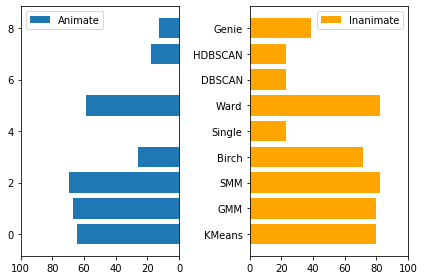

In [76]:
#D' histogram for animate and inanimate double bars for different clustering techniques

labels = ['KMeans','GMM','SMM','Birch','Single','Ward','DBSCAN','HDBSCAN','Genie']
animate_means = [64.10,66.67,69.23, 25.64,0,58.97,0,17.59,12.82]
inanimate_means = [79.49,79.49,82.05,71.79,23.07,82.07,23.07,23.07,38.46]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

ax = plt.subplot(1,2,1)
ax.barh(x, animate_means, label='Animate')
# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_xlabel('Performance Impact')
#ax.set_title('Performance by Class')
#ax.set_yticks(x)
#ax.set_yticklabels(labels,rotation=0)
ax.legend()
plt.xlim([0,100])
ax.invert_xaxis()

ax = plt.subplot(1,2,2)
ax.barh(x, inanimate_means, label='Inanimate', color='orange')
# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_xlabel('Performance Impact')
#ax.set_title('Performance by Class')
ax.set_yticks(x)
ax.set_yticklabels(labels,rotation=0)
ax.legend()
plt.xlim([0,100])
plt.tight_layout()
def autolabel(rects, xpos='center'):
    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom',size=8)
        
#autolabel(rects1)
#autolabel(rects2)
plt.savefig('../../results/clustering_results.eps', format='eps')

In [ ]:
fig, ax = plt.subplots()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75)
hb =  ax.hexbin(X[:,0],X[:,1],bins='log') 
fig.colorbar(hb)
plt.xlim([-2.2,8000])
plt.ylim([-2.2,8000])


In [ ]:
fig, ax = plt.subplots()
ax.scatter(X[:,0],X[:,1])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=1)
plt.xlim([-2.2,8000])
plt.ylim([-2.2,8000])
print(X.shape)

In [ ]:
print(ana,ina, set(pred))

In [ ]:
fig, ax = plt.subplots()
label_loc = np.where(pred==ana)[0]
#print len(label_loc)
Zx = []
Zy = []
for i in range(len(label_loc)):
    temp = np.where(pred_kmeans==label_loc[i])[0]
    for i in temp:
        Zx.append(X[i][0])
        Zy.append(X[i][1])
#print len(np.where(Z!=0)[0])
print(len(Zx))
sc = plt.scatter(Zx,Zy) 
plt.xlim([-2.2,300])
plt.ylim([-2.2,300])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=1)
plt.xlabel('Animate')
plt.ylabel('Inanimate')
plt.title('Most selective cluster for animate class')
plt.savefig('../../results/scree/'+str(method)+'_results_ana.png', format='png')

In [ ]:
fig, ax = plt.subplots()
label_loc = np.where(pred==ina)[0]
print(len(label_loc))
Zx = []
Zy = []
for i in range(len(label_loc)):
    temp = np.where(pred_kmeans==label_loc[i])[0]
    for i in temp:
        Zx.append(X[i][0])
        Zy.append(X[i][1])
sc = plt.scatter(Zx,Zy) 
plt.xlim([-2.2,300])
plt.ylim([-2.2,300])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=1)
plt.xlabel('Animate')
plt.ylabel('Inanimate')
plt.title('Most selective cluster for inanimate class')
plt.savefig('../../results/scree/'+str(method)+'_results_ina.png', format='png')

In [ ]:
label_loc = np.where(pred==ana)[0]
Z = []
for i in range(len(label_loc)):
    temp = np.where(pred_kmeans==label_loc[i])[0]
    for i in temp:
        Z.append(i)
print(max(Z))

In [ ]:
label_loc = np.where(pred==ana)[0]
Z = []
for i in range(len(label_loc)):
    temp = np.where(pred_kmeans==label_loc[i])[0]
    for i in temp:# Create a ClassificationModel
        Z.append(i)
X = np.arange(15)
Y = np.zeros((15,))

for i in Z:
    if i in range(0,3211264): 
        Y[0] += 1
    elif i in range(3211264,6422528):
        Y[1] += 1
    elif i in range(6422528,8028160):
        Y[2] += 1
    elif i in range(8028160,9633792):
        Y[3] += 1
    elif i in range(9633792,10436608):
        Y[4] += 1
    elif i in range(10436608,11239424):
        Y[5] += 1
    elif i in range(11239424,12042240):
        Y[6] += 1
    elif i in range(12042240,12443648):
        Y[7] += 1
    elif i in range(12443648,12845056):
        Y[8] += 1
    elif i in range(12845056,13246464):
        Y[9] += 1
    elif i in range(13246464,13346816):
        Y[10] += 1
    elif i in range(13346816,13447168):
        Y[11] += 1
    elif i in range(13447168,13547520):
        Y[12] += 1
    elif i in range(13547520,13551616):
        Y[13] += 1
    elif i in range(13551616,13555712):
        Y[14] += 1
    else:
        print(i)

Y[0] = float(Y[0]) /3211264
Y[1] = float(Y[0]) / 3211264
Y[2] = float(Y[2]) / 1605632
Y[3] = float(Y[3]) / 1605632
Y[4] = float(Y[4]) / 802816
Y[5] = float(Y[5]) /802816
Y[6] = float(Y[6]) /802816
Y[7] = float(Y[7]) /401408
Y[8] = float(Y[8]) /401408
Y[9] = float(Y[9]) /401408
Y[10] = float(Y[10]) /100352
Y[11] = float(Y[11]) /100352
Y[12] = float(Y[12]) /100352
Y[13] = float(Y[13]) /4096
Y[14] = float(Y[14]) /4096

plt.ylim([0,1.])
rect = plt.bar(X,Y)
plt.xticks(X, ('conv_1_1', 'conv_1_2', 'conv_2_1','conv_2_2','conv_3_1','conv_3_2','conv_3_3','conv_4_1','conv_4_2','conv_4_3','conv_5_1','conv_5_2', 'conv_5_3','fc1','fc2'))
plt.ylabel('Relative count of neurons')
plt.title('Neurons from the animate cluster')
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#autolabel(rect)
plt.savefig('../../results/scree/'+str(method)+'_results_ana_hist_alt.png', format='png')

In [ ]:
label_loc = np.where(pred==ina)[0]
Z = []# Create a ClassificationModel
for i in range(len(label_loc)):
    temp = np.where(pred_kmeans==label_loc[i])[0]
    for i in temp:
        Z.append(i)
X = np.arange(15)
Y = np.zeros((15,))

for i in Z:
    if i in range(0,3211264): 
        Y[0] += 1
    elif i in range(3211264,6422528):
        Y[1] += 1
    elif i in range(6422528,8028160):
        Y[2] += 1
    elif i in range(8028160,9633792):
        Y[3] += 1
    elif i in range(9633792,10436608):
        Y[4] += 1
    elif i in range(10436608,11239424):
        Y[5] += 1
    elif i in range(11239424,12042240):
        Y[6] += 1
    elif i in range(12042240,12443648):
        Y[7] += 1
    elif i in range(12443648,12845056):
        Y[8] += 1
    elif i in range(12845056,13246464):
        Y[9] += 1
    elif i in range(13246464,13346816):
        Y[10] += 1
    elif i in range(13346816,13447168):
        Y[11] += 1
    elif i in range(13447168,13547520):
        Y[12] += 1
    elif i in range(13547520,13551616):
        Y[13] += 1
    elif i in range(13551616,13555712):
        Y[14] += 1
    else:
        print(i)

Y[0] = float(Y[0]) /3211264
Y[1] = float(Y[0]) / 3211264
Y[2] = float(Y[2]) / 1605632
Y[3] = float(Y[3]) / 1605632
Y[4] = float(Y[4]) / 802816
Y[5] = float(Y[5]) /802816
Y[6] = float(Y[6]) /802816
Y[7] = float(Y[7]) /401408
Y[8] = float(Y[8]) /401408
Y[9] = float(Y[9]) /401408
Y[10] = float(Y[10]) /100352
Y[11] = float(Y[11]) /100352
Y[12] = float(Y[12]) /100352
Y[13] = float(Y[13]) /4096
Y[14] = float(Y[14]) /4096

plt.ylim([0,1.])
rect = plt.bar(X,Y)
plt.ylabel('Relative count of neurons')
plt.title('Neurons from the inanimate cluster')
plt.xticks(X, ('conv_1_1', 'conv_1_2', 'conv_2_1','conv_2_2','conv_3_1','conv_3_2','conv_3_3','conv_4_1','conv_4_2','conv_4_3','conv_5_1','conv_5_2', 'conv_5_3','fc1','fc2'))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#autolabel(rect)
plt.savefig('../../results/scree/'+str(method)+'_results_ina_hist_alt.png', format='png')

In [ ]:
label_loc = np.where(pred==ina)[0]
Z = []
for i in range(len(label_loc)):
    temp = np.where(pred_kmeans==label_loc[i])[0]
    for i in temp:
        Z.append(i)
X = np.arange(7)
Y = np.zeros((7,))

print(len(Z))